# Infinite Systems: iTEBD Ground States and State Preparation Circuits

So far we have worked with **finite** MPS and MPO. In this notebook we move to **infinite** systems, where the state is translation-invariant and described by a small unit cell of tensors repeated infinitely.

## Key concepts

- **iMPS (infinite MPS)**: Represented in **Vidal canonical form** with site tensors $\Gamma^{[s]}$ and diagonal bond matrices $\Lambda$. This form makes truncation clean and enables efficient imaginary-time evolution.

- **iTEBD (imaginary Time Evolving Block Decimation)**: Applies $e^{-\beta H}$ in small Trotter steps to an initial state, projecting onto the ground state as $\beta \to \infty$. The bond dimension $\chi$ controls accuracy.

- **State preparation circuits**: Once we have a ground state iMPS, we compile a parameterized quantum circuit $U$ such that $U|0\rangle \approx |\psi_{\mathrm{gs}}\rangle$.

In this notebook you will:
1. Find TFIM ground states with iTEBD and track energy convergence
2. Map out the TFIM phase diagram by sweeping the transverse field
3. Find the Heisenberg antiferromagnet ground state and compare to the exact Bethe ansatz
4. Compile a state preparation circuit and study training convergence
5. Investigate how circuit depth affects state preparation fidelity
6. Study how bond dimension $\chi$ controls iTEBD accuracy

## Setup

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using TenSynth
using TenSynth.Core
using TenSynth.iMPS

using LinearAlgebra
using Random
using Plots
gr()

Random.seed!(42)
println("TenSynth loaded successfully.")

  Activating 

TenSynth loaded successfully.


project at `~/Documents/Programming/PhD/ClaudeCodeExperiments/TenSynth_Master/TenSynthRepo/TenSynth`


## 1. Finding the TFIM Ground State with iTEBD

The transverse-field Ising model (TFIM) on an infinite chain:

$$H = -J \sum_i Z_i Z_{i+1} - h \sum_i X_i$$

has a quantum phase transition at $h/J = 1$. We use iTEBD with imaginary-time evolution to find the ground state at the critical point.

The exact ground state energy per site is:

$$\frac{E}{N} = -\frac{1}{2\pi} \int_0^{2\pi} \sqrt{J^2 + h^2 + 2Jh\cos k} \, dk$$

At $J = h = 1$, this evaluates to $-4/\pi \approx -1.2732$.

In [2]:
# Find the TFIM ground state at the critical point h/J = 1
result_tfim = itebd_tfim_ground_state(2, 1.0, 1.0; max_chi=32, verbose=false)

E_exact_critical = -4/π  # Exact infinite-chain result at h=J=1

println("TFIM ground state (h/J = 1.0, critical point):")
println("  iTEBD energy/site:  $(round(result_tfim.energy, digits=6))")
println("  Exact energy/site:  $(round(E_exact_critical, digits=6))")
println("  Error:              $(round(abs(result_tfim.energy - E_exact_critical), sigdigits=3))")
println("  Converged:          $(result_tfim.converged)")
println("  Bond dimension:     $(max_bond_dimension(result_tfim.psi))")
println("  iTEBD steps:        $(length(result_tfim.energy_history))")

TFIM ground state (h/J = 1.0, critical point):
  iTEBD energy/site:  -1.272326
  Exact energy/site:  -1.27324
  Error:              0.000914
  Converged:          true
  Bond dimension:     26
  iTEBD steps:        87


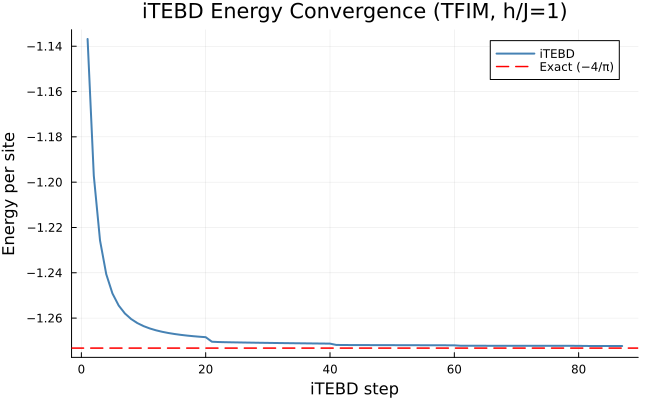

In [3]:
# Plot energy convergence during iTEBD
p = plot(result_tfim.energy_history,
    xlabel="iTEBD step", ylabel="Energy per site",
    title="iTEBD Energy Convergence (TFIM, h/J=1)",
    linewidth=2, color=:steelblue, label="iTEBD",
    size=(650, 400))

hline!(p, [E_exact_critical], linestyle=:dash, color=:red,
    linewidth=1.5, label="Exact (−4/π)")

p

The energy rapidly converges to the exact value $E/\text{site} = -4/\pi \approx -1.2732$ as the imaginary time step $\delta\tau$ is decreased through the schedule. Each plateau corresponds to a different $\delta\tau$ value. With $\chi = 32$, the error is less than $10^{-3}$.

## 2. TFIM Phase Diagram

The TFIM has two phases:
- **Ordered phase** ($h/J < 1$): $\langle Z \rangle \neq 0$, ground state approaches $|\!\uparrow\uparrow\cdots\rangle$
- **Disordered phase** ($h/J > 1$): $\langle X \rangle \approx 1$, ground state approaches $|\!+\!+\!\cdots\rangle$

Let's sweep $h/J$ and compute the ground state energy at each point.

In [4]:
h_values = [0.2, 0.5, 0.8, 1.0, 1.5, 2.0, 3.0]
energies = Float64[]

for h in h_values
    res = itebd_tfim_ground_state(2, 1.0, h; max_chi=32, verbose=false)
    push!(energies, res.energy)
end

# Print results
println("h/J     E/site")
println("─" ^ 22)
for (h, E) in zip(h_values, energies)
    println("$(rpad(h, 8))$(round(E, digits=6))")
end

h/J     E/site
──────────────────────
0.2     -1.009905
0.5     -1.062081
0.8     -1.161386
1.0     -1.272326
1.5     -1.671918
2.0     -2.127079
3.0     -3.083917


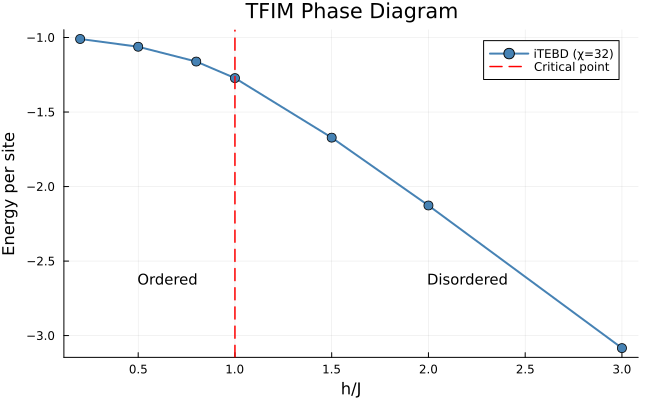

In [5]:
p = plot(h_values, energies,
    xlabel="h/J", ylabel="Energy per site",
    title="TFIM Phase Diagram",
    marker=:circle, linewidth=2, markersize=5,
    color=:steelblue, label="iTEBD (χ=32)",
    size=(650, 400))

vline!(p, [1.0], linestyle=:dash, color=:red,
    linewidth=1.5, label="Critical point")

annotate!(p, 0.5, minimum(energies) * 0.85, text("Ordered", 10, :left))
annotate!(p, 2.0, minimum(energies) * 0.85, text("Disordered", 10, :left))

p

The energy decreases monotonically with increasing field strength. The critical point at $h/J = 1$ separates the ordered (low-field) and disordered (high-field) phases. The non-analytic behavior of the energy near the critical point signals the quantum phase transition.

## 3. Heisenberg Antiferromagnet

The spin-1/2 Heisenberg antiferromagnet with full Pauli matrices:

$$H = J \sum_i (X_i X_{i+1} + Y_i Y_{i+1} + Z_i Z_{i+1})$$

The Bethe ansatz gives the exact ground state energy per site $E/N = 1 - 4\ln 2 \approx -1.7726$ (in Pauli matrix convention; the spin-1/2 result $\frac{1}{4} - \ln 2$ is four times smaller).

We use a **Néel state** $|\!\uparrow\downarrow\uparrow\downarrow\cdots\rangle$ as the initial state for iTEBD, since the $|+\rangle$ product state is an eigenstate of $XX + YY + ZZ$ and would not evolve.

In [6]:
# Use Néel state as initial state (|+⟩ is trapped for Heisenberg)
H_heis = TenSynth.iMPS.HeisenbergHamiltonian(2; J=1.0)
psi_heis = random_product_state(2)
neel_state!(psi_heis)

config_heis = iTEBDConfig(max_chi=32, verbose=false)
result_heis = itebd_ground_state!(psi_heis, H_heis; config=config_heis)

E_bethe = 1 - 4*log(2)  # Bethe ansatz for Pauli convention: 4*(1/4 - ln2)

println("Heisenberg antiferromagnet ground state:")
println("  iTEBD energy/site:  $(round(result_heis.energy, digits=6))")
println("  Bethe ansatz:       $(round(E_bethe, digits=6))")
println("  Error:              $(round(abs(result_heis.energy - E_bethe), sigdigits=3))")
println("  Converged:          $(result_heis.converged)")
println("  Bond dimension:     $(max_bond_dimension(result_heis.psi))")

Heisenberg antiferromagnet ground state:
  iTEBD energy/site:  -1.771899
  Bethe ansatz:       -1.772589
  Error:              0.000689
  Converged:          true
  Bond dimension:     32


## 4. State Preparation: Compiling a Circuit for the Ground State

Now we compile a parameterized quantum circuit $U$ such that $U|0\rangle \approx |\psi_{\mathrm{gs}}\rangle$. The circuit uses a **nearest-neighbour ansatz** — layers of two-qubit gates on adjacent pairs with periodic boundary conditions.

We target the TFIM ground state near the critical point ($h/J = 1.01$), where the entanglement is high and more circuit layers are needed for an accurate state preparation. The optimizer minimizes the infidelity $1 - |\langle \psi_{\mathrm{gs}} | U | 0 \rangle|^{2/n}$ by adjusting the gate parameters.

In [7]:
# Use the TFIM ground state near the critical point (high entanglement)
Random.seed!(123)
target_state = itebd_tfim_ground_state(2, 1.0, 1.01; max_chi=64, verbose=false)
psi_target = target_state.psi

# Create initial |0...0⟩ state
psi_init = random_product_state(2)
zero_state!(psi_init)

# Create a 4-layer nearest-neighbour ansatz with DressedZZ parameterization
n_layers = 4
ansatz = nearest_neighbour_ansatz(2, n_layers, DressedZZParameterization())

# Randomize initial circuit parameters (default is zeros)
Random.seed!(42)
set_params!(ansatz, 0.1 * randn(n_params(ansatz)))

println("Ansatz: $(n_gates(ansatz)) gates, $(n_params(ansatz)) parameters")
println("Target state bond dimension: $(max_bond_dimension(psi_target))")

# Compile the state preparation circuit
config = StateCompilationConfig(
    max_chi=32,
    optimizer=:lbfgs,
    max_iter=50,
    converge_tol=1e-10,
    verbose=false
)

comp_result = compile_state_preparation(psi_init, psi_target, ansatz; config=config)

println("\nCompilation result:")
println("  Fidelity:  $(round(comp_result.train_fidelity, sigdigits=6))")
println("  Converged: $(comp_result.converged)")

Ansatz: 8 gates, 56 parameters
Target state bond dimension: 13

Compilation result:
  Fidelity:  0.990493
  Converged: false


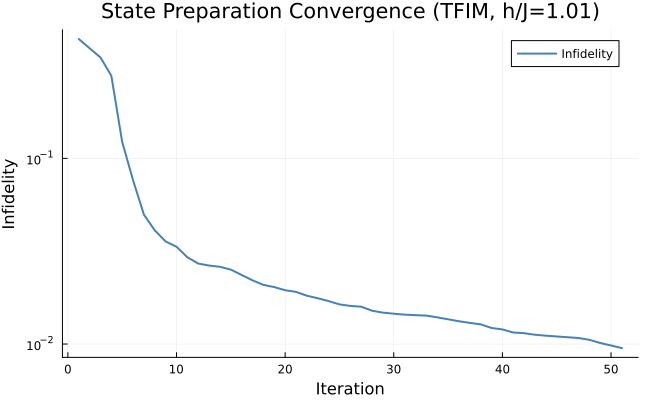

In [8]:
# Plot training convergence
p = plot(title="State Preparation Convergence (TFIM, h/J=1.01)",
         xlabel="Iteration", ylabel="Infidelity",
         yscale=:log10, size=(650, 400))

plot!(p, 1:length(comp_result.train_history), comp_result.train_history,
      linewidth=2, color=:steelblue, label="Infidelity")

p

Since state preparation optimizes a single cost function (the infidelity between $U|0\rangle$ and $|\psi_{\mathrm{gs}}\rangle$), there is no train/test split — the convergence plot shows the single objective being minimized. The L-BFGS optimizer typically converges within tens of iterations. Near the critical point the ground state has high entanglement, making it harder to approximate with a shallow circuit.

## 5. Depth Scaling: How Many Layers Are Needed?

We compile the same ground state at increasing circuit depths to see how fidelity improves with more layers.

In [9]:
layer_counts = [1, 2, 3, 4]
depth_fidelities = Float64[]

config_depth = StateCompilationConfig(
    max_chi=32, optimizer=:lbfgs, max_iter=50,
    converge_tol=1e-10, verbose=false
)

for nl in layer_counts
    Random.seed!(42 + nl)
    a = nearest_neighbour_ansatz(2, nl, DressedZZParameterization())
    set_params!(a, 0.1 * randn(n_params(a)))  # Random initial params
    psi0 = random_product_state(2)
    zero_state!(psi0)
    res = compile_state_preparation(psi0, psi_target, a; config=config_depth)
    push!(depth_fidelities, res.train_fidelity)
    println("Layers=$nl ($(n_gates(a)) gates, $(n_params(a)) params): ",
            "fidelity = $(round(res.train_fidelity, sigdigits=6))")
end

Layers=1 (2 gates, 14 params): fidelity = 0.952051
Layers=2 (4 gates, 28 params): fidelity = 0.975493
Layers=3 (6 gates, 42 params): fidelity = 0.985149
Layers=4 (8 gates, 56 params): fidelity = 0.986963


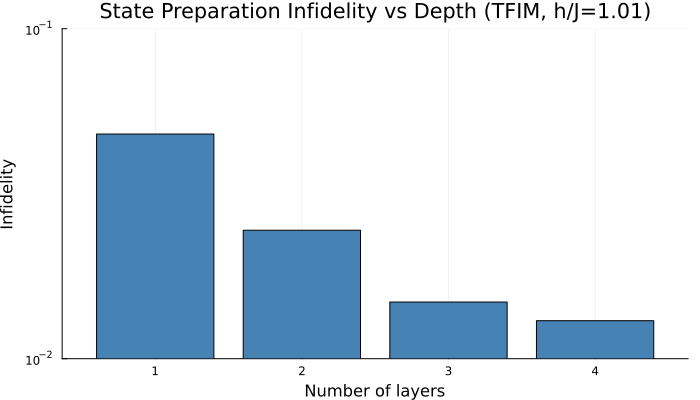

In [10]:
p = bar(string.(layer_counts), 1 .- depth_fidelities,
    ylabel="Infidelity", xlabel="Number of layers",
    title="State Preparation Infidelity vs Depth (TFIM, h/J=1.01)",
    legend=false, color=:steelblue, size=(700, 400),
    yscale=:log10, ylim=(1e-2, 1e-1))

p

Near the critical point ($h/J = 1.01$), the ground state has significant entanglement, so the fidelity improves noticeably with circuit depth. Deeper circuits can capture more of the entanglement structure, yielding higher fidelity. This is in contrast to low-entanglement states (e.g. deep in the ordered phase), where even a single layer suffices.

## 6. Bond Dimension Convergence

The bond dimension $\chi$ of the iMPS controls how much entanglement can be captured. Higher $\chi$ gives more accurate ground states but costs more computation. Let's see how the energy converges with $\chi$.

In [11]:
chi_values = [4, 8, 16, 32]
chi_energies_ordered = Float64[]      # h/J = 0.5 (ordered)
chi_energies_nearcrit = Float64[]     # h/J = 1.001 (near-critical)

for chi in chi_values
    res_ord = itebd_tfim_ground_state(2, 1.0, 0.5; max_chi=chi, verbose=false)
    res_nc = itebd_tfim_ground_state(2, 1.0, 1.001; max_chi=chi, verbose=false)
    push!(chi_energies_ordered, res_ord.energy)
    push!(chi_energies_nearcrit, res_nc.energy)
    println("χ=$(rpad(chi, 4)) ordered: $(round(res_ord.energy, digits=6)),  ",
            "near-critical: $(round(res_nc.energy, digits=6))")
end

χ=4    ordered: -1.062076,  near-critical: -1.272971
χ=8    ordered: -1.062081,  near-critical: -1.27299
χ=16   ordered: -1.062081,  near-critical: -1.27299
χ=32   ordered: -1.062081,  near-critical: -1.27299


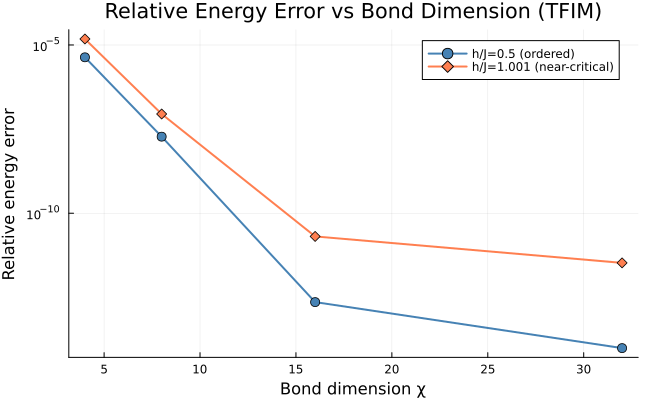

In [12]:
# Compute exact energies for reference
E_exact_ordered = itebd_tfim_ground_state(2, 1.0, 0.5; max_chi=128, verbose=false).energy
E_exact_nearcrit = itebd_tfim_ground_state(2, 1.0, 1.001; max_chi=128, verbose=false).energy

rel_err_ordered = abs.((chi_energies_ordered .- E_exact_ordered) ./ E_exact_ordered)
rel_err_nearcrit = abs.((chi_energies_nearcrit .- E_exact_nearcrit) ./ E_exact_nearcrit)

p = plot(title="Relative Energy Error vs Bond Dimension (TFIM)",
         xlabel="Bond dimension χ", ylabel="Relative energy error",
         legend=:topright, size=(650, 400), yscale=:log10)

plot!(p, chi_values, rel_err_ordered,
    marker=:circle, linewidth=2, markersize=5,
    color=:steelblue, label="h/J=0.5 (ordered)")

plot!(p, chi_values, rel_err_nearcrit,
    marker=:diamond, linewidth=2, markersize=5,
    color=:coral, label="h/J=1.001 (near-critical)")

p

The ordered-phase ground state ($h/J = 0.5$) converges quickly because it has low entanglement — even $\chi = 4$ gives an accurate energy. The near-critical state ($h/J = 1.001$) converges more slowly because the entanglement entropy diverges logarithmically near the critical point, requiring larger bond dimensions for the same accuracy.

## 7. Verifying the Compiled Circuit

Let's verify the state preparation circuit by applying it to the initial state and computing the fidelity with the target.

In [13]:
# Apply the compiled circuit to a fresh |0⟩ state
psi_test = random_product_state(2)
zero_state!(psi_test)

apply_circuit!(psi_test, comp_result.circuit; max_chi=64)
absorb_bonds!(psi_test)

# Compute fidelity with target
F = local_fidelity(psi_test, psi_target)
inf = infidelity(psi_test, psi_target)

println("Verification:")
println("  Local fidelity:  $(round(F, sigdigits=6))")
println("  Infidelity:      $(round(inf, sigdigits=4))")
println("  Bond dim after circuit: $(max_bond_dimension(psi_test))")

# Also check the energy (use iMPS module's Hamiltonian for compute_energy compatibility)
H_target = TenSynth.iMPS.TFIMHamiltonian(2; J=1.0, h=1.01)
E_compiled = compute_energy(psi_test, H_target)
println("  Energy (compiled): $(round(E_compiled, digits=6))")
println("  Energy (target):   $(round(target_state.energy, digits=6))")

Verification:
  Local fidelity:  0.990493
  Infidelity:      0.009507
  Bond dim after circuit: 15
  Energy (compiled): -1.252094
  Energy (target):   -1.279007


## Summary

In this notebook you learned:

- How **iTEBD** uses imaginary time evolution to find iMPS ground states
- The TFIM **phase diagram** shows a quantum phase transition at $h/J = 1$
- The **Heisenberg antiferromagnet** ground state energy matches the Bethe ansatz result
- **State preparation circuits** can be compiled by optimizing parameterized gate ansatze
- Circuit **depth scaling** shows that near-critical states with high entanglement benefit from deeper circuits
- **Bond dimension** $\chi$ controls iTEBD accuracy, with critical-point states converging more slowly

**Key functions used:**
- `itebd_tfim_ground_state(unit_cell, J, h; max_chi, verbose)` — TFIM ground state via iTEBD
- `itebd_heisenberg_ground_state(unit_cell; J, max_chi, verbose)` — Heisenberg ground state
- `compute_energy(psi, H)` — Energy expectation value
- `nearest_neighbour_ansatz(n_qubits, n_layers, param)` — Parameterized circuit ansatz
- `compile_state_preparation(psi_init, psi_target, ansatz; config)` — State preparation compiler
- `local_fidelity(psi, phi)` / `infidelity(psi, phi)` — State comparison
- `apply_circuit!(psi, circuit; max_chi)` — Apply parameterized circuit to iMPS

**Next**: Notebook 07 tackles a harder problem — compiling time evolution **unitaries** on infinite chains.